This notebook is an analysis of the errors in relative free energy calculations on the Schrödinger JACS dataset:
> Wang, L., Wu, Y., Deng, Y., Kim, B., Pierce, L., Krilov, G., ... & Romero, D. L. (2015). Accurate and reliable prediction of relative ligand binding potency in prospective drug discovery by way of a modern free-energy calculation protocol and force field. Journal of the American Chemical Society, 137(7), 2695-2703.

http://doi.org/10.1021/ja512751q

as reported in the AMBER TI chemRixv manuscript:

> Validation of AMBER/GAFF for Relative Free Energy Calculations
Preprint submitted on 02.02.2019, 15:29 and posted on 04.02.2019, 15:08 by Lin Song Tai-Sung Lee Chun Zhu Darrin M. York Kenneth M. Merz Jr.

https://chemrxiv.org/articles/Validation_of_AMBER_GAFF_for_Relative_Free_Energy_Calculations/7653434

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pylab as plt
import sklearn.metrics
import scipy.stats

In [2]:
# Read the dataset
systems = ['bace', 'cdk2', 'jnk1', 'mcl1', 'p38a', 'ptp1b', 'thrombin', 'tyk2']
dfs = dict() # dfs[system] is the pandas dataframe for system 'system'
for system in systems:
    # Why do people still use Excel in 2019, for pete's sake?
    df = pd.read_excel('amber-ti/FEP_vs_GTI-dG-SI.xlsx', sheet_name=system)
    # Column headers have irregular names, so fix them
    df = df.rename(index=str, columns={"ccc_ddG": "ccc_FEP", "CCC": "ccc_TI"})
    # Delete empty rows
    rows_to_drop = list()
    for i, row in df.iterrows():
        if str(df.loc[i,'exp_ddG']) == 'nan':
            rows_to_drop.append(i)
    df = df.drop(index=rows_to_drop);
    # Only keep useful columns
    df = df.filter(items=['Ligand1', 'Ligand2','exp_ddG', 'ccc_FEP', 'ccc_TI'])
    # Store the dataframe
    dfs[system] = df

In [3]:
def bootstrap_statistic(y_true, y_pred, ci=0.95, statistic='RMSE', nbootstrap = 1000):
    """Compute mean and confidence intervals of specified statistic.
    
    Parameters
    ----------
    y_true : ndarray with shape (N,)
        True values
    y_pred : ndarray with shape (N,)
        Predicted values
    ci : float, optional, default=0.95
        Interval for CI
    statistic : str
        Statistic, one of ['RMSE', 'MUE', 'R2', 'rho']
    nbootstrap : int, optional. default=10000
        Number of bootstrap samples
        
    Returns
    -------
    rmse_stats : dict of floeat
        'mean' : mean RMSE
        'stderr' : standard error
        'low' : low end of CI
        'high' : high end of CI
    """
    
    def compute_statistic(y_true_sample, y_pred_sample, statistic):
        """Compute requested statistic.
        
        Parameters
        ----------
        y_true : ndarray with shape (N,)
            True values
        y_pred : ndarray with shape (N,)
            Predicted values
        statistic : str
            Statistic, one of ['RMSE', 'MUE', 'R2', 'rho']
            
        """
        if statistic == 'RMSE':
            return np.sqrt(sklearn.metrics.mean_squared_error(y_true_sample, y_pred_sample))
        elif statistic == 'MUE':
            return sklearn.metrics.mean_absolute_error(y_true_sample, y_pred_sample)
        elif statistic == 'R2':
            return sklearn.metrics.r2_score(y_true_sample, y_pred_sample)
        elif statistic == 'rho':
            return scipy.stats.pearsonr(y_true_sample, y_pred_sample)[0]
        else:
            raise Exception("unknown statistic '{}'".format(statistic))
            
    assert len(y_true) == len(y_pred)
    sample_size = len(y_true)
    s_n = np.zeros([nbootstrap], np.float64) # s_n[n] is the statistic computed for bootstrap sample n
    for replicate in range(nbootstrap):
        indices = np.random.choice(np.arange(sample_size), size=[sample_size])
        s_n[replicate] = compute_statistic(y_true[indices], y_pred[indices], statistic)
                
    rmse_stats = dict()
    rmse_stats['mean'] = compute_statistic(y_true, y_pred, statistic)
    rmse_stats['stderr'] = np.std(s_n)
    
    # TODO: Is there a canned method to do this?
    s_n = np.sort(s_n)
    low_frac = (1.0-ci)/2.0
    high_frac = 1.0 - low_frac
    rmse_stats['low'] = s_n[int(np.floor(nbootstrap*low_frac))]
    rmse_stats['high'] = s_n[int(np.ceil(nbootstrap*high_frac))]

    return rmse_stats

bace
cdk2
jnk1
mcl1
p38a
ptp1b
thrombin
tyk2


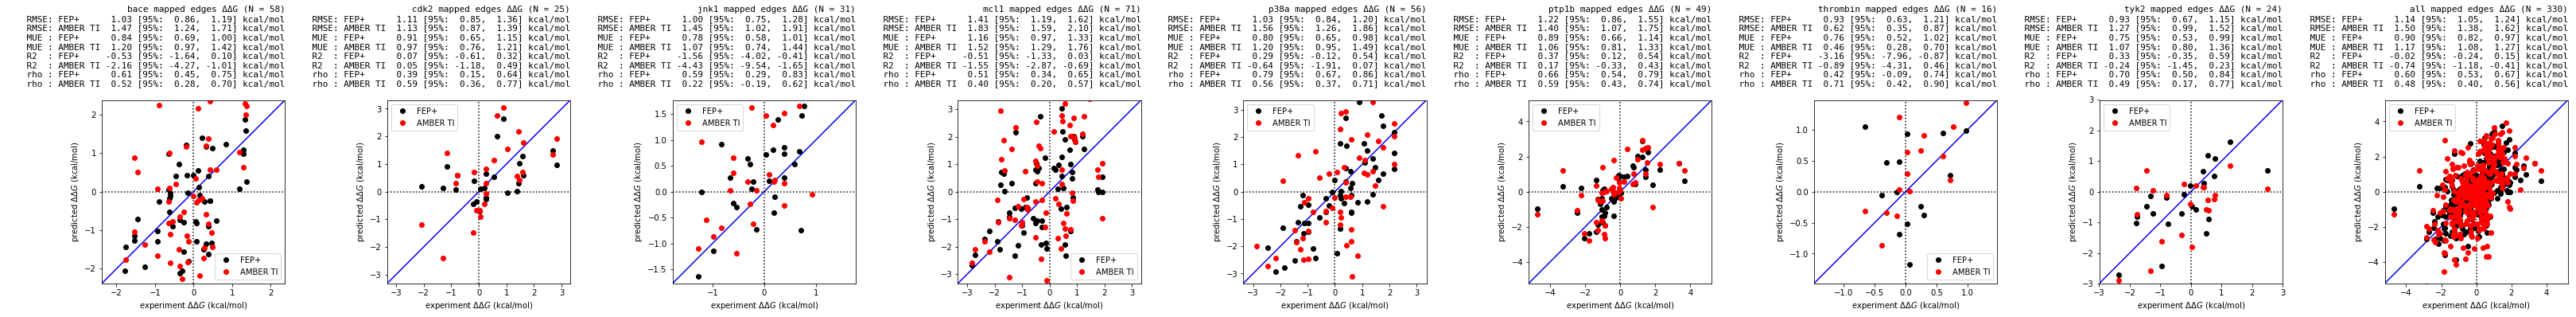

In [4]:
# Plot data by system
def plot_data(rows):
    """
    Plot predicted vs experimental ddG for FEP+ and AMBER TI.
    
    Parameters
    ----------
    rows : pd.Dataframe
        Pandas dataframe containing 'exp_ddG', 'ccc_FEP', and 'ccc_TI' columns
        
    """
    nsamples = len(rows['exp_ddG'].values)
    xmin = min([rows['exp_ddG'].values.min() for label in ('exp_ddG', 'ccc_FEP', 'ccc_TI')])
    xmax = max([rows['exp_ddG'].values.max() for label in ('exp_ddG', 'ccc_FEP', 'ccc_TI')])
    xmax = + (max(abs(xmin), abs(xmax)) + 0.5)
    xmin = - xmax
    plt.xlabel('experiment $\Delta \Delta G$ (kcal/mol)');
    plt.ylabel('predicted $\Delta \Delta G$ (kcal/mol)');
    plt.plot([xmin, xmax], [xmin, xmax], 'b-');
    plt.plot([0, 0], [xmin, xmax], 'k:');
    plt.plot([xmin, xmax], [0, 0], 'k:');
    hFEP = plt.plot(rows['exp_ddG'].values, rows['ccc_FEP'].values, 'ko');
    hTI = plt.plot(rows['exp_ddG'].values, rows['ccc_TI'].values, 'ro');
    plt.legend([hFEP[0], hTI[0]], ['FEP+', 'AMBER TI'])

    # Compute error statistics
    stats = { 
        (method,statistic) : bootstrap_statistic(rows['exp_ddG'].values, rows['ccc_'+method].values, statistic=statistic) 
        for method in ('FEP', 'TI') 
        for statistic in ('RMSE', 'MUE', 'R2', 'rho') 
    }
    
    # Label plot with error statistics
    title = """{} mapped edges ΔΔG (N = {})
    RMSE: FEP+     {:5.2f} [95%: {:5.2f}, {:5.2f}] kcal/mol
    RMSE: AMBER TI {:5.2f} [95%: {:5.2f}, {:5.2f}] kcal/mol
    MUE : FEP+     {:5.2f} [95%: {:5.2f}, {:5.2f}] kcal/mol
    MUE : AMBER TI {:5.2f} [95%: {:5.2f}, {:5.2f}] kcal/mol
    R2  : FEP+     {:5.2f} [95%: {:5.2f}, {:5.2f}] kcal/mol
    R2  : AMBER TI {:5.2f} [95%: {:5.2f}, {:5.2f}] kcal/mol
    rho : FEP+     {:5.2f} [95%: {:5.2f}, {:5.2f}] kcal/mol
    rho : AMBER TI {:5.2f} [95%: {:5.2f}, {:5.2f}] kcal/mol
    """.format(system, nsamples, 
               stats[('FEP','RMSE')]['mean'], stats[('FEP','RMSE')]['low'], stats[('FEP','RMSE')]['high'],
               stats[('TI','RMSE')]['mean'], stats[('TI','RMSE')]['low'], stats[('TI','RMSE')]['high'],
               stats[('FEP','MUE')]['mean'], stats[('FEP','MUE')]['low'], stats[('FEP','MUE')]['high'],
               stats[('TI','MUE')]['mean'], stats[('TI','MUE')]['low'], stats[('TI','MUE')]['high'],
               stats[('FEP','R2')]['mean'], stats[('FEP','R2')]['low'], stats[('FEP','R2')]['high'],
               stats[('TI','R2')]['mean'], stats[('TI','R2')]['low'], stats[('TI','R2')]['high'],
               stats[('FEP','rho')]['mean'], stats[('FEP','rho')]['low'], stats[('FEP','rho')]['high'],
               stats[('TI','rho')]['mean'], stats[('TI','rho')]['low'], stats[('TI','rho')]['high'],
               )
    plt.title(title, fontsize=11, loc='right', horizontalalignment='right', family='monospace');
    
    plt.axis('square');
    plt.xlim(xmin, xmax);
    plt.ylim(xmin, xmax);

# Plot all systems
nsystems = len(systems)
ny = 1
nx = nsystems+1 # plot one row with summary statistics above
fig = plt.figure(figsize=[45,7])
for plot_index, system in enumerate(systems):
    print(system)
    plt.subplot(ny, nx, plot_index+1)
    rows = dfs[system]
    plot_data(rows)
    
# Plot analysis of all ddG data
df = pd.concat(dfs.values())
plt.subplot(ny, nx, nsystems+1)
system = 'all'
plot_data(df)

# Write out figure to a file
fig.tight_layout()
fig.savefig('fepplus-vs-ti-mapped-edges-ddG.pdf');